### link to perceptron.py ###

For my perceptron.grad() implementation (without mini-batching) I first calculate the score and then simply return 1.0*(s_i*y_i < 0)*y*X. This correctly implements the math of the perceptron algorithm as we are performing the perceptron update: w = w + y_i*x_i only if s_i*y_i < 0 which the first half of our return statement is doing. As for the mini-batching, I declared an alpha value and then calculate k based on the size of the batch that has been supplied to the grad() method. Then I set up a for loop compounding what I call the total grad for each value of the mini-batch, I then average that and multiply it by our learning rate and then return.

## Abstract

The high level purpose of this blog is to explore the Perceptron, a very basic linear classifier. The perceptron is a useful tool to find a weight value for a classifier while minimizing loss however this can only be accomplished if the data is linearly separable so the applications of this model are quite limited. In the follow experiments I aim to confirm my implementation of the perceptron algorithm and to explore how it fairs when dealing with 2 dimensional data, 2 dimensional non-linearly separable data, and multidimensional data.

In [39]:
%load_ext autoreload
%autoreload 2
from perceptron import Perceptron, PerceptronOptimizer

The following perceptron data function is taken from Professor Chodrows implementation in the live notes

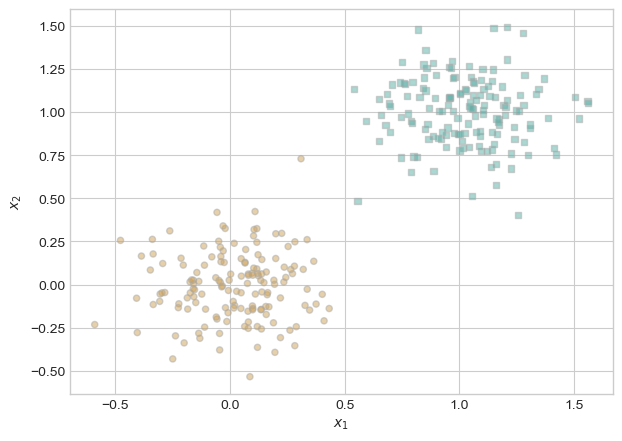

In [40]:
import torch
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

torch.manual_seed(1234)

def perceptron_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # convert y from {0, 1} to {-1, 1}
    y = 2*y - 1

    return X, y

X, y = perceptron_data(n_points = 300, noise = 0.2)

def plot_perceptron_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [-1, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1)
X, y = perceptron_data()
plot_perceptron_data(X, y, ax)

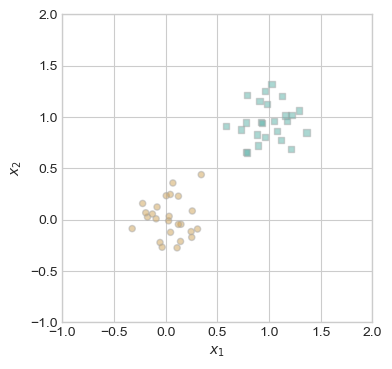

In [138]:
X, y = perceptron_data(n_points = 50, noise = 0.2)
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X, y, ax)

Above we show a visualization of the data we are about to apply the perceptron algorithm to. We can see our main training loop below

In [139]:
# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X.size()[0]

while loss > 0: # dangerous -- only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)
    
    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)

Inside our main loop is pretty simple we are calculating the overall loss from our data X and y and then picking a random data point from X and y and passing that to our step function. Inside the step function we will call the perceptron.grad() function mentioned at the beginning of the blog and we will update the weight accordingly. This loop is completed until the loss is 0.

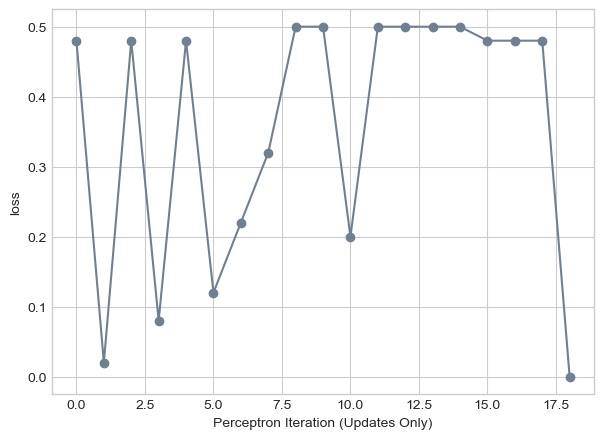

In [141]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

Above we can see a visualization of the loss over time as the perceptron algorithm runs as we can see there is quite a bit of ups and downs, but in just 20 iterations of the loop we reach a weight value that produces 0 loss.

The following code blocks are taken from Professor Chodrow's - Introduction to Classification: The Perceptron

In [92]:
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

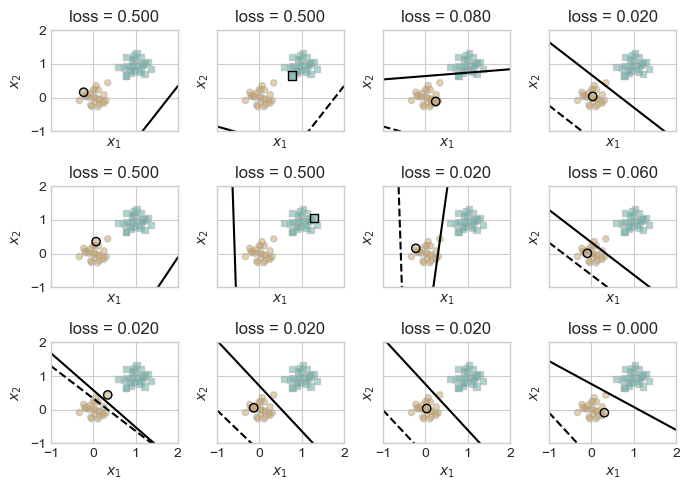

In [145]:
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

# set up the figure
plt.rcParams["figure.figsize"] = (7, 5)
fig, axarr = plt.subplots(3, 4, sharex = True, sharey = True)
markers = ["o", ","]
marker_map = {-1 : 0, 1 : 1}

# initialize for main loop
current_ax = 0
loss = 1
loss_vec = []

while loss > 0:
    ax = axarr.ravel()[current_ax]

    # save the old value of w for plotting later
    old_w = torch.clone(p.w)

    # make an optimization step -- this is where the update actually happens
    # now p.w is the new value 
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    local_loss = opt.step(x_i, y_i)

    # if a change was made, plot the old and new decision boundaries
    # also add the new loss to loss_vec for plotting below
    if local_loss > 0:
        plot_perceptron_data(X, y, ax)
        draw_line(old_w, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")
        loss = p.loss(X, y).item()
        loss_vec.append(loss)
        draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")
        ax.scatter(X[i,0],X[i,1], color = "black", facecolors = "none", edgecolors = "black", marker = markers[marker_map[y[i].item()]])
        # draw_line(w, -10, 10, ax, color = "black")
        ax.set_title(f"loss = {loss:.3f}")
        ax.set(xlim = (-1, 2), ylim = (-1, 2))
        current_ax += 1
plt.tight_layout()

While the above graph is a little messy it does show the trend for the separating line being decided based off the changing weight value and how that is related to the loss as the algorithm progresses.

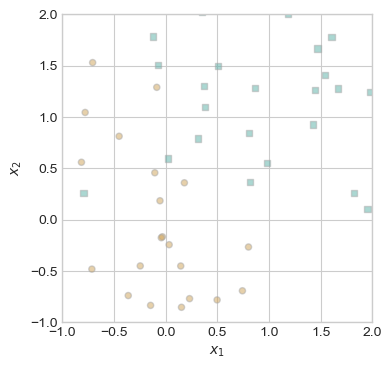

In [103]:
X, y = perceptron_data(n_points = 50, noise = 0.7)
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X, y, ax)

Now we're moving on to an experiment that deals with data that is not linearly separable, by increasing the noise in the perceptron data function we can produce a data set that is not linearly separable and see how the algorithm fairs here

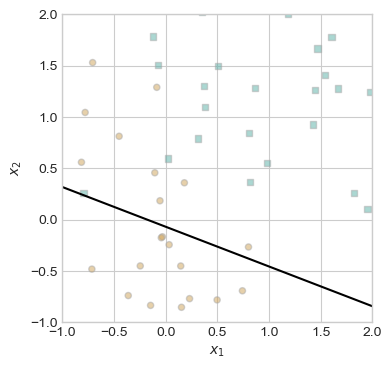

In [104]:
from perceptron import Perceptron, PerceptronOptimizer
p = Perceptron()
opt = PerceptronOptimizer(p)
p.loss(X, y)

# initialize for main loop
current_ax = 0
loss = 1
loss_vec = []

max_iterations = 1000
j = 0

while loss > 0:
    if j > max_iterations:
        break

    loss = p.loss(X, y) 
    loss_vec.append(loss)
    
    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)
    j+=1


fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X, y, ax)
draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")

After running our training loop for 1000 iterations we still don't have a separating line that really tells us anything there are still quite a few orange circles above the line and below

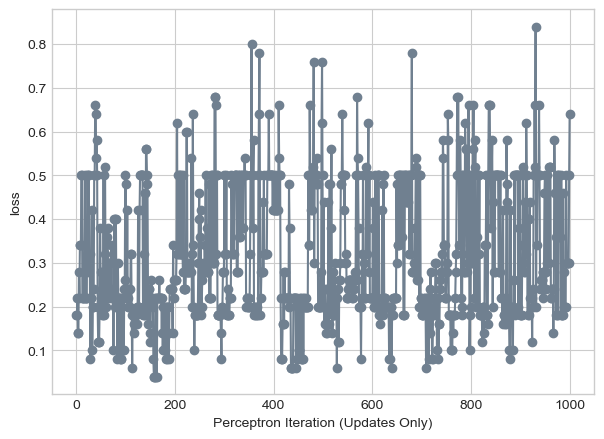

In [105]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

A similar trend can be seen in the loss where we bounce up and down without ever reaching 0 even after 1000 iterations

In [66]:
X, y = perceptron_data(n_points = 50, noise = 0.2, p_dims=5)

Now we're experimenting with a dataset that has five dimensions in its feature matrix instead of just 2, and in doing so we can check if this data set is linearly separable or not depending on if we can apply the perceptron to this data.

In [67]:
# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X.size()[0]

while loss > 0: # dangerous -- only terminates if data is linearly separable
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)
    
    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    
    # perform a perceptron update using the random data point
    opt.step(x_i, y_i)

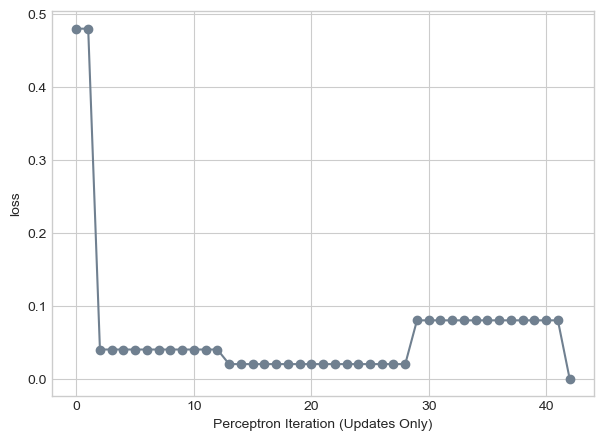

In [68]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

Following our main training loop and we can see this data should be linearly separable as we were able to reach a loss score of 0 after training. The loss hovers very close to 0 for quite a bit of time and then jumps down at the end.

In [156]:
def perceptron_mini_batch_training(X, y, k, max_iterations):
    # instantiate a model and an optimizer
    p = Perceptron() 
    opt = PerceptronOptimizer(p)

    loss = 1.0

    # for keeping track of loss values
    loss_vec = []

    n = X.size()[0]

    k = k
    ix = torch.randperm(X.size(0))[:k]
    j = 0
    max_iterations = max_iterations

    while loss > 0: # dangerous -- only terminates if data is linearly separable
        if j > max_iterations:
            break
        
        # not part of the update: just for tracking our progress    
        loss = p.loss(X, y) 
        loss_vec.append(loss)
        
        # pick a random data point
        # i = torch.randint(n, size = (1,))
        # x_i = X[[i],:]
        # y_i = y[i]
        ix = torch.randperm(X.size(0))[:k]
        X_k = X[ix,:]
        y_k = y[ix]
        
        # perform a perceptron update using the random data point
        opt.step(X_k, y_k)
        j += 1
        
    # plt.plot(loss_vec, color = "slategrey")
    # plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
    # labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")
    fig, ax = plt.subplots(1, 1, figsize = (4, 4))
    ax.set(xlim = (-1, 2), ylim = (-1, 2))
    plot_perceptron_data(X, y, ax)
    draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")
    

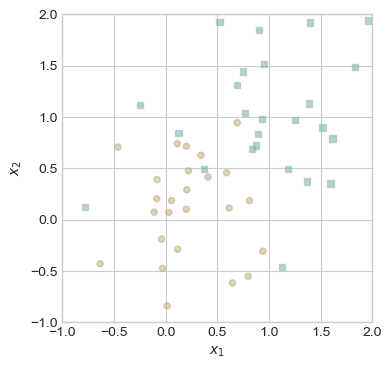

In [81]:
X, y = perceptron_data(n_points = 50, noise = 0.5)
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X, y, ax)

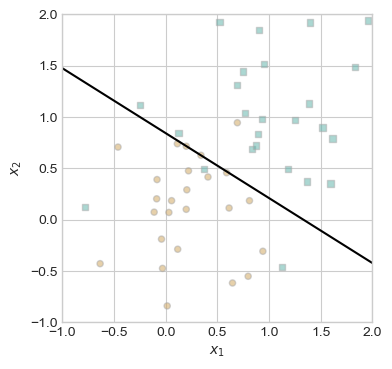

In [86]:
# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0

# for keeping track of loss values
loss_vec = []

n = X.size()[0]

k = n
j = 0
max_iterations = 10000

while loss > 0: # dangerous -- only terminates if data is linearly separable
    if j > max_iterations:
        break
    
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    loss_vec.append(loss)
    
    # pick a random data point
    # i = torch.randint(n, size = (1,))
    # x_i = X[[i],:]
    # y_i = y[i]
    ix = torch.randperm(X.size(0))[:k]
    X_k = X[ix,:]
    y_k = y[ix]
    
    # perform a perceptron update using the random data point
    opt.step(X_k, y_k)
    j += 1

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X, y, ax)
draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black")

Here we are demonstrating that with a k value set to n we can still converge even when the data is not linearly separable as is the case with the above dataset. This can be seen visually with the line above generally splitting the data evenly and below in the graph of the loss where it gets exteremely close to 0 and doesn't have any spikes above that.

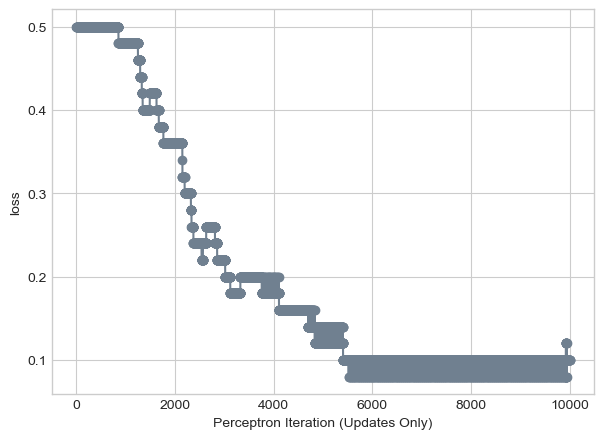

In [87]:
plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

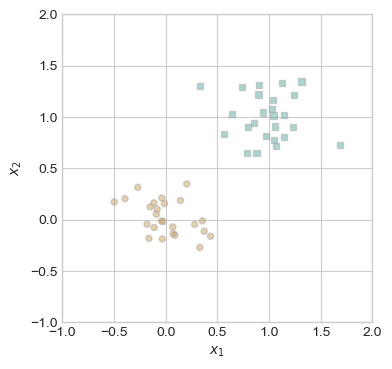

In [147]:
X, y = perceptron_data(n_points = 50, noise = 0.2)
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
ax.set(xlim = (-1, 2), ylim = (-1, 2))
plot_perceptron_data(X, y, ax)

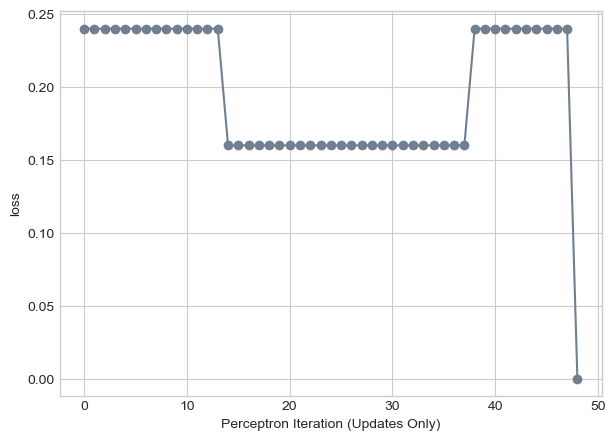

In [155]:
perceptron_mini_batch_training(X, y, k=1, max_iterations = 1000)

The above example shows the loss plot of the perceptron with mini-batching when k = 1, and as we can see it does indeed fair quite similarly to the normal perceptron algorithm.

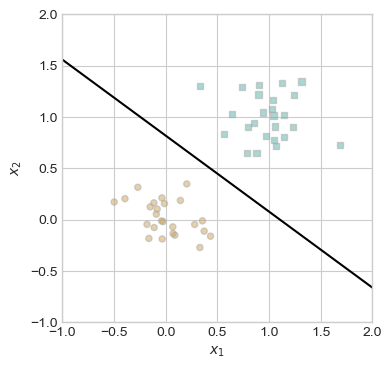

In [157]:
perceptron_mini_batch_training(X, y, k=10, max_iterations = 1000)

Now we can see that in the case of a mini-batch with k=10 the algorithm can still find a separating line in 2d.

### Runtime discussion

Thinking about the time complexity of a single iteration of the perceptron algorithm the major things that happen are a loss calculation, the random selection of a data point, and the optimization step. The loss calculation is just simple arithmetic so that will be O(1), the random selection is also constant so O(1), and the optimization step calls loss O(1) and grad which in the case of the normal perceptron is again just arithmetic so it too is O(1). So the basic algorithm has a constant runtime for its iterations making it quite efficient.

For the case of mini-batching the only difference is that in my implementation I have a for loop that runs in range k so each iteration will be O(k) so in the best case O(1) and in the worst O(n)

## Discussion

Looking back at the work done in this blog post we can see that the perceptron is an efficient algorithm to use when dealing with a linearly separable dataset. If the data being worked with is not linearly separable then mini-batching is a possible solution to make the algorithm more effective. However, it still is not perfect and doesn't always achieve 0 loss. The perceptron is an interesting algorithm, but the scope of the data for which it can be used is quite narrow.